# Trabajo Fin de Grado - Ingeniería de Software
## Entrenamiento del modelo de detección de expresiones faciales


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
classes = {
    0: "Neutral",
    1: "Happiness",
    2: "Sadness",
    3: "Surprise",
    4: "Anger", 
    #4: "Fear",
    #5: "Disgust",
}

In [ ]:
fer_classes = {
    0: "neutral",
    1: "happy",
    2: "sad",
    3: "surprise", 
    4: "angry",
    #4: "fear",
}

fer_classes_cor = {
    "neutral": "Neutral",
    "happy": "Happiness",
    "sad": "Sadness",
    "surprise": "Surprise",
    "angry": "Anger"
}

In [ ]:
train_set_dir = './dataset/train_data'
val_set_dir = './dataset/val_data'
test_set_dir = './dataset/test_data'

In [ ]:
fer_train_set_dir = './dataset2/train'
fer_val_set_dir = './dataset2/test'

# Descargar FER

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp "./gdrive/MyDrive/Colab Notebooks/Data/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -q -o challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d ./tmp_dataset
!tar -xf ./tmp_dataset/fer2013.tar.gz --directory ./tmp_dataset

 96% 273M/285M [00:02<00:00, 182MB/s]
100% 285M/285M [00:02<00:00, 143MB/s]


## Mejora de las labels del dataset con FERPlus

In [ ]:
!git clone https://github.com/microsoft/FERPlus.git

Cloning into 'FERPlus'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 650.37 KiB | 12.51 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [ ]:
!python FERPlus/src/generate_training_data.py -d tmp_dataset2 -fer ./tmp_dataset/fer2013/fer2013.csv -ferplus ./FERPlus/fer2013new.csv

Start generating ferplus images.
Done...


In [ ]:
!cp -r FERPlus/data/* tmp_dataset2/

In [ ]:
import csv
import sys

emotion_ferplus = ['neutral', 'happy', 'surprise', 'sad', 'angry', 'disgust', 'fear', 'contempt']

os.system(f'mkdir ./dataset2')
os.system(f'mkdir {fer_train_set_dir}')
os.system(f'mkdir {fer_val_set_dir}')  
for _e in emotion_ferplus:
  os.system(f'mkdir {fer_val_set_dir}/{_e}')  
  os.system(f'mkdir {fer_train_set_dir}/{_e}')


for folder_name in ['FER2013Test', 'FER2013Train', 'FER2013Valid']:
  in_label_path = os.path.join('./tmp_dataset2', folder_name, 'label.csv')
  with open(in_label_path) as csvfile: 
    emotion_label = csv.reader(csvfile) 
    for row in emotion_label: 
      image_path = os.path.join('./tmp_dataset2', folder_name, row[0])

      emotion_raw = list(map(float, row[2:len(row)]))
      size = len(emotion_raw)
      emotion_unknown     = [0.0] * size
      emotion_unknown[-2] = 1.0

      # Elimina las emociones con un solo "voto"
      for i in range(size):
        if emotion_raw[i] < 1.0 + sys.float_info.epsilon:
          emotion_raw[i] = 0.0

      sum_list = sum(emotion_raw)

      # Encuentra la emocion con el mayor número de votos
      maxval = max(emotion_raw) 
      if maxval > 0.5*sum_list: 
        emotion = np.argmax(emotion_raw)
        dest = fer_val_set_dir if folder_name == 'FER2013Valid' else fer_train_set_dir
        if(emotion <= len(emotion_ferplus) - 1):
          os.system(f'mv {image_path} {dest}/{emotion_ferplus[emotion]}') 



In [ ]:
# Elimina todos los directorios que no se van a usar en el entrenamiento
for directory in list(os.listdir(fer_train_set_dir)):
  if(directory not in list(fer_classes.values())):
    os.system(f'rm -r {os.path.join(fer_train_set_dir,directory)}') 


for directory in list(os.listdir(fer_val_set_dir)):
  if(directory not in list(fer_classes.values())):
    os.system(f'rm -r {os.path.join(fer_val_set_dir,directory)}') 


# Cargar Affectnet desde Google Drive

In [ ]:
!mkdir ./dataset

!cp /content/gdrive/MyDrive/TFG/affectnet_reduced/train_set.tar ./dataset/
!cp /content/gdrive/MyDrive/TFG/affectnet_reduced/val_set.tar ./dataset/

!tar -xf ./dataset/train_set.tar -C ./dataset/
!tar -xf ./dataset/val_set.tar -C ./dataset/

# Formateo de AffectNet

In [ ]:
def prepare_data(input_dir, output_dir):
    os.mkdir(output_dir)

    for _c in classes.values():
        os.mkdir(os.path.join(output_dir, _c))

    test_images_unorganized = list(os.listdir(os.path.join(input_dir, 'images')))
    for _f in test_images_unorganized:
        n_split = _f.split('.')[0]
        folder = classes.get(int(np.load(os.path.join(input_dir, 'annotations', f'{n_split}_exp.npy'))), None)

        if folder and os.path.exists(os.path.join(output_dir, folder)):
          os.system(f'cp {os.path.join(input_dir,"images", _f)} {os.path.join(output_dir, folder)}') 

In [ ]:
try:
  os.system(f'rm -r {val_set_dir}')
except Exception:
  pass

try:
  os.system(f'rm -r {train_set_dir}')
except Exception:
  pass

prepare_data('./dataset/val_set/', val_set_dir)
prepare_data('./dataset/train_set/', train_set_dir)

# Creación del dataset de test

In [ ]:
import random


for directory in list(os.listdir(fer_train_set_dir)):
  images = os.listdir(os.path.join(fer_train_set_dir, directory))
  random.Random(1).shuffle(images)
  tests_samples = images[int((len(images)+1)*.80):]
  os.system(f'mkdir {os.path.join(test_set_dir)}') 
  os.system(f'mkdir {os.path.join(test_set_dir, fer_classes_cor[directory])}') 

  for img in tests_samples:
    os.system(f'mv {os.path.join(fer_train_set_dir,directory,img)} {os.path.join(test_set_dir, fer_classes_cor.get(directory))}/') 


# Combinado de los datasets

In [ ]:
for directory in list(os.listdir(fer_train_set_dir)):
  os.system(f'mv {os.path.join(fer_train_set_dir,directory)}/* {os.path.join(train_set_dir, fer_classes_cor.get(directory))}/') 

for directory in list(os.listdir(fer_val_set_dir)):
  os.system(f'mv {os.path.join(fer_val_set_dir,directory)}/* {os.path.join(val_set_dir, fer_classes_cor.get(directory))}/') 

# Constantes de entrenamiento

In [ ]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 1)
batch_size = 64

class_names = list(classes.values())


## Visualizando los datos de entrenamiento

## Preparación de los datos para optimización de hiper parámetros

In [ ]:
import cv2

search_x = []
search_y = []



for directory in list(os.listdir(val_set_dir)):
  images = os.listdir(os.path.join(val_set_dir, directory))
  for img in images:
    img_np = cv2.imread(os.path.join(val_set_dir, directory, img))
    img_np = cv2.resize(img_np, (img_width, img_height))
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    search_x.append(img_np)
    search_y.append(directory)

search_x = np.asarray(search_x)
search_y = np.asarray(search_y)

search_x = search_x.reshape(-1, img_width, img_height, 1)

search_x.shape


Found 277052 files belonging to 5 classes.
Found 5590 files belonging to 5 classes.
Found 5457 files belonging to 5 classes.


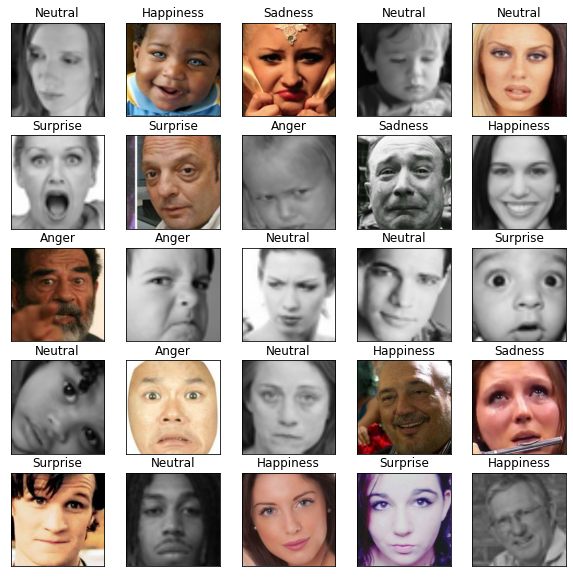

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


train_ds = image_dataset_from_directory(
    train_set_dir, labels='inferred', label_mode='categorical',
    class_names=class_names, color_mode='rgb', batch_size=batch_size, image_size=(img_width, img_height)
    , shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
val_ds = image_dataset_from_directory(
    val_set_dir, labels='inferred', label_mode='categorical',
    class_names=class_names, color_mode='rgb', batch_size=batch_size, image_size=(img_width, img_height)
    , shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)
test_ds = image_dataset_from_directory(
    test_set_dir, labels='inferred', label_mode='categorical',
    class_names=class_names, color_mode='rgb', batch_size=batch_size, image_size=(img_width, img_height)
    , shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)
test_ds = test_ds.prefetch(buffer_size=batch_size)

sample_size = 25
cols = 5
rows = sample_size // cols
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
    for i in range(sample_size):
        img = images[i].numpy() / 255.0
        plt.subplot(rows, cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])

## Visualizando las augmentations

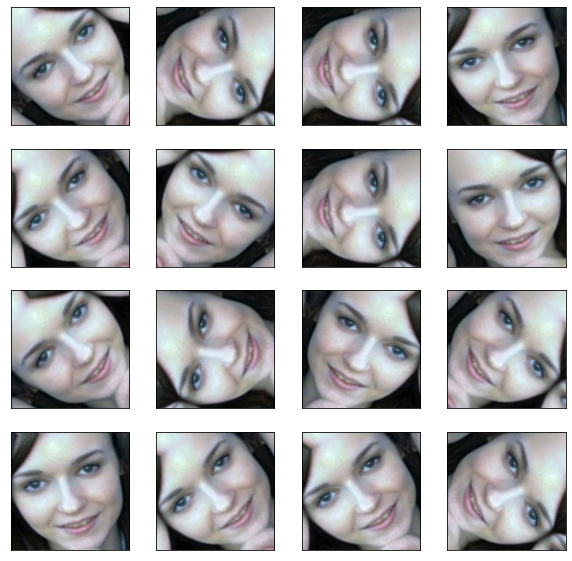

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow as tf


augmentation = Sequential ([
  Resizing(img_width, img_height),
  Rescaling(1./255),
  RandomFlip("horizontal"),
  RandomRotation(0.2),
]) 


sample_size = 16
cols = 4
rows = sample_size // cols
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(sample_size):
        augmented_images = augmentation(images)
        img = augmented_images[0].numpy()
        plt.subplot(rows, cols, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)

## Definición del modelo


In [ ]:
from tensorflow.keras.optimizers import *

def create_model(learning_rate=0.001, dense_units=128, dropout1=0.3, dropout2=0.25, n_channels=1):
  
    m = Sequential([
      augmentation,
      Conv2D(32, (3, 3), input_shape=(img_width, img_height,n_channels), padding='same', activation='relu'),
      BatchNormalization(),
      Conv2D(32, (3, 3), input_shape=(img_width, img_height,n_channels), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(dropout1),

      Conv2D(64, (3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      Conv2D(64, (3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(dropout1),

      Conv2D(128, (3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      Conv2D(128, (3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(dropout1),

      Conv2D(256, (3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      Conv2D(256, (3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(dropout1),

      Flatten(),
      Dense(dense_units, activation = "relu"),
      BatchNormalization(),
      Dropout(dropout2),

      Dense(dense_units / 2, activation = "relu"),
      BatchNormalization(),
      Dropout(dropout2),

      Dense(5, activation = "softmax"),

    ]) 

    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])    # TODO: Compilación del modelo

    return m


In [ ]:
from tensorflow.keras.optimizers import *
import tensorflow as tf

def create_model_transfer(learning_rate=0.001, dense_units=256, dropout1=0, dropout2=0.5, n_channels=1):
    m_base = tf.keras.applications.Xception(weights='imagenet',include_top=False,input_shape=(img_width, img_height, 3))
    #for layer in m_base.layers[:30]:
      #layer.trainable = False


    #for (i,layer) in enumerate(m_base.layers):
      #print(str(i),layer.__class__.__name__,layer.trainable)

    m_base.trainable = False

    def addTopModelMobileNet(bottom_model):
        """creates the top or head of the model that will be 
        placed ontop of the bottom layers"""

        top_model = bottom_model.output

        top_model = Flatten()(top_model)
        top_model = BatchNormalization()(top_model)
        top_model = Dense(dense_units,activation='relu')(top_model)
        top_model = Dropout(dropout2)(top_model)

        top_model = Flatten()(top_model)
        top_model = BatchNormalization()(top_model)
        top_model = Dense(dense_units / 2,activation='relu')(top_model)
        top_model = Dropout(dropout2)(top_model)

        top_model = Flatten()(top_model)
        top_model = BatchNormalization()(top_model)
        top_model = Dense(dense_units / 4,activation='relu')(top_model)
        top_model = Dropout(dropout2)(top_model)


        top_model = Dense(3,activation='softmax')(top_model)

        return top_model

    FC_Head = addTopModelMobileNet(m_base)

    m_tmp = Model(inputs = m_base.input, outputs = FC_Head)
    m = Sequential([
      augmentation,
      m_tmp
    ])

    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 
    
    return m


## Entrenamiento


In [ ]:
# Ejecutar para eliminar los checkpoints de una ejecución anterior
!rm -r /content/gdrive/MyDrive/TFG/checkpoints-fer

rm: cannot remove '/content/gdrive/MyDrive/TFG/checkpoints-fer': No such file or directory


## Búsqueda de hiper parámetros

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Semilla aleatoria
seed = 7
numpy.random.seed(seed)

# Modelo
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=batch_size, verbose=1)

learning_rate = [0.001, 0.01, 0.1] # 0.001
dense_units = [128, 64, 256] # 128
dropout1 = [0.5, 0.25, 0.1]
dropout2 = [0.5, 0.25, 0.1]

#learning_rate = [0.001]
#dense_units = [128]
#dropout1 = [0.3]
#dropout2 = [0.3]

param_grid = dict(learning_rate=learning_rate, dense_units=dense_units)
param_grid2 = dict(dropout1=dropout1, dropout2=dropout2)

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=None, cv=5)
#grid = GridSearchCV(estimator=model, param_grid=param_grid2, n_jobs=None, cv=5)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid2, n_jobs=None, cv=5)

grid_result = grid.fit(search_x, search_y)

# Resultados
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#model = create_model_transfer()
model = create_model()

### Celda para cargar un modelo entrenado anteriormente con Transfer Learning para hacer fine tuning


In [ ]:
from keras import backend as K
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/TFG/checkpoints-ferPLUS-transfer/model-07-0.62.hdf5')
model.trainable = True
K.set_value(model.optimizer.learning_rate, 0.00001)
model.summary()

### Celda para cargar un modelo entrenado anteriormente para seguir el entrenamiento

In [ ]:
#from keras.models import load_model
#model = load_model('/content/gdrive/MyDrive/TFG/checkpointsc/model-32-0.59.hdf5')

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from datetime import datetime

logdir = "/content/gdrive/MyDrive/TFG/logs/checkpoint-ferPLUS" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)


checkpoint = ModelCheckpoint(
  "/content/gdrive/MyDrive/TFG/checkpoints-ferPLUS/model-{epoch:02d}-{val_accuracy:.2f}.hdf5",
  monitor='val_accuracy',
  verbose=1,
  save_best_only=True, 
  mode='max'
)

earlystop = EarlyStopping(
  monitor='val_accuracy',
  min_delta=0,
  patience=6,
  verbose=1,
  restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
  monitor='val_accuracy',
  factor=0.95,
  patience=3,
  verbose=1,
  min_delta=0.0001
)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[checkpoint, earlystop, reduce_lr, tensorboard_callback])

## Guardando el modelo

Guardamos el modelo con sus pesos entrenados en nuestro Google Drive. Es importante que la ruta de destino exista en drive.


In [ ]:
from keras.models import load_model

path = './gdrive/MyDrive/modelos_ml/vico_practica2.h5' 
model.summary()
model.save(path)

## Evolución de las métricas


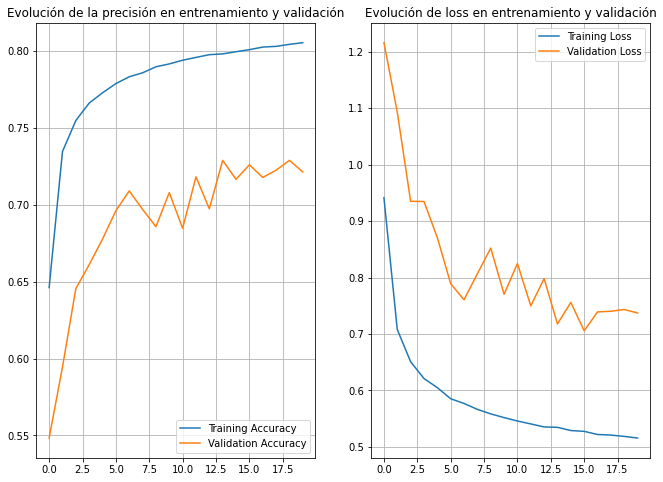

In [ ]:
def show_training_graph(data):
  acc = data.history['accuracy']
  val_acc = data.history['val_accuracy']
  loss = data.history['loss']
  val_loss = data.history['val_loss']

  epochs = range(len(acc))
  plt.figure(figsize=(11, 8))
  plt.subplot(1, 2, 1)
  plt.grid(True)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Evolución de la precisión en entrenamiento y validación')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.grid(True)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Evolución de loss en entrenamiento y validación')
  plt.legend(loc='upper right')

  plt.show()

show_training_graph(history)

## Evaluación del modelo

In [ ]:
model.evaluate(test_ds)

86/86 [==============================] - 5s 54ms/step - loss: 0.4831 - accuracy: 0.8217


[0.48310860991477966, 0.8216968774795532]

In [ ]:
plt.figure(figsize=(14, 70))
sample_size = 100
cols = 5
rows = sample_size // cols

for images, labels in test_ds.take(1):
  for i in range(sample_size):
    img = images[i].numpy()
    img = img.reshape((1,) + img.shape)
    prediction = np.argmax(model.predict(img, batch_size=1)[0])
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[0]/255)
    plt.title(f'P: {class_names[prediction]}\nR: {class_names[np.argmax(labels[i])]}')